# S&P 500 Stock Price Prediction

***

## This script implements a machine learning project to predict S&P 500 stock prices. The analysis includes:
### - Exploratory Data Analysis (EDA)
### - Data cleaning and preprocessing
### - Feature selection
### - Model implementation and comparison (Linear Regression and LSTM)

***

### Import required libraries

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
import os
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')

### Set style for plots

In [8]:
plt.style.use('default')
sns.set_theme(style="whitegrid")

***

# 1. Data Collection and EDA

## Load the Dataset

Our project uses historical stock data from Yahoo Finance's public API. To improve efficiency, we check if a local CSV file (`sp500.csv`) exists. If it does, we load the data from the file. Otherwise, we fetch the data from Yahoo Finance using the `yfinance` library and save it locally for future use.

This dataset contains daily trading data for the S&P 500 index.

In [13]:
def download_data():
    if os.path.exists("sp500.csv") and os.path.getsize("sp500.csv") > 0:
        sp500 = pd.read_csv("sp500.csv", index_col=0)
        print(f"Data loaded successfully from CSV. Shape: {sp500.shape}")
    else:
        sp500 = yf.Ticker("^GSPC")
        sp500 = sp500.history(period="max")
        sp500.to_csv("sp500.csv")
        print(f"Data fetched successfully from yfinance. Shape: {sp500.shape}")
    
    sp500.index = pd.to_datetime(sp500.index, utc=True)
    return sp500

df = download_data()

Data loaded successfully from CSV. Shape: (24434, 7)


## Add the technical indicators to the dataset

We enhance our dataset by computing a wide range of technical indicators. These are commonly used in financial analysis and trading algorithms to identify trends, momentum, volatility, and other patterns in stock prices.

The indicators added include:

- **Simple Moving Averages (SMA)**: 5-day, 20-day, and 50-day.
- **Exponential Moving Averages (EMA)**: 12-day and 26-day.
- **MACD and MACD Signal Line**: To capture trend-following momentum.
- **RSI (Relative Strength Index)**: Measures overbought or oversold conditions.
- **Bollinger Bands**: Tracks price volatility and upper/lower bounds.
- **ATR (Average True Range)**: Represents market volatility.
- **Volume Indicators**: Volume SMA and relative volume change.
- **Momentum**: Measures the rate of price change over time.
- **Volatility**: Rolling standard deviation of returns.
- **Price Range and Price Change**: Measures intra-day spread and day-to-day movement.

These features are useful for modeling the behavior of stock prices and capturing both short-term and long-term trends.

In [16]:
def add_technical_indicators(df):
    # Calculate returns
    df['Returns'] = df['Close'].pct_change()
    
    # Calculate moving averages
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    # Calculate exponential moving averages
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    
    # Calculate MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Calculate Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=20).std()
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=20).std()
    
    # Calculate Average True Range (ATR)
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(window=14).mean()
    
    # Calculate Volume indicators
    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Change'] = df['Volume'].pct_change()
    
    # Calculate price momentum
    df['Momentum'] = df['Close'] - df['Close'].shift(10)
    
    # Calculate price volatility
    df['Volatility'] = df['Returns'].rolling(window=20).std()
    
    # Calculate price range
    df['Price_Range'] = (df['High'] - df['Low']) / df['Close']
    
    # Calculate price change
    df['Price_Change'] = df['Close'].diff()
    
    # Drop rows with NaN values (from rolling calculations)
    df = df.dropna()
    
    return df

df = add_technical_indicators(df)

df.to_csv("sp500_with_indicators.csv")

## Data Cleaning

### Show initial data shape before cleaning process

In [19]:
print("\nInitial data shape:", df.shape)


Initial data shape: (18938, 26)


### Calculate percentage of missing values in each column

In [21]:
missing_cols = df.isnull().mean() * 100
print("\nPercentage of missing values in each column:")
print(missing_cols)


Percentage of missing values in each column:
Open             0.0
High             0.0
Low              0.0
Close            0.0
Volume           0.0
Dividends        0.0
Stock Splits     0.0
Returns          0.0
SMA_5            0.0
SMA_20           0.0
SMA_50           0.0
EMA_12           0.0
EMA_26           0.0
MACD             0.0
MACD_Signal      0.0
RSI              0.0
BB_Middle        0.0
BB_Upper         0.0
BB_Lower         0.0
ATR              0.0
Volume_SMA       0.0
Volume_Change    0.0
Momentum         0.0
Volatility       0.0
Price_Range      0.0
Price_Change     0.0
dtype: float64


### Remove columns with more than 70% missing values

Drop columns where more than 70% of values are missing, as they likely contain insufficient data.

In [24]:
cols_to_drop = missing_cols[missing_cols > 70].index
if len(cols_to_drop) > 0:
    print(f"\nRemoving columns with >70% missing values: {list(cols_to_drop)}")
    df = df.drop(columns=cols_to_drop)

### Calculate percentage of missing values in each row

In [26]:
missing_rows = df.isnull().mean(axis=1) * 100

### Remove rows with more than 70% missing values

Similarly, remove rows where more than 70% of the data is missing.

In [29]:
rows_before = len(df)
df = df[missing_rows <= 70]
rows_removed = rows_before - len(df)
print(f"\nRemoved {rows_removed} rows with >70% missing values")


Removed 0 rows with >70% missing values


### Fill remaining missing values using linear interpolation

Apply linear interpolation to fill remaining missing values. This helps maintain continuity in the time series data without introducing abrupt changes.

In [32]:
print("\nFilling remaining missing values using interpolation...")
df_before_interpolation = df.copy()
df = df.interpolate(method='linear', limit_direction='both')


Filling remaining missing values using interpolation...


### Calculate how many values were interpolated

In [34]:
total_interpolated = (df_before_interpolation.isnull().sum().sum())
print(f"Interpolated {total_interpolated} missing values")

Interpolated 0 missing values


### Display final data shape after clenaing process

In [36]:
print("\nFinal data shape:", df.shape)


Final data shape: (18938, 26)


### Check if any missing values remain

In [38]:
remaining_missing = df.isnull().sum().sum()
if remaining_missing > 0:
    print(f"\nWarning: {remaining_missing} missing values remain after cleaning")
else:
    print("\nAll missing values have been handled")


All missing values have been handled


## Performing Exploratory Data Analysis

We explore the structure, distribution, and relationships within the dataset through statistical summaries and visualizations. This allows us to build intuition about the data and uncover patterns that can inform our modeling decisions.

### View statistics after previous cleaning

We examine basic descriptive statistics such as mean, standard deviation, min/max values, and quartiles. This helps identify potential outliers, scale mismatches, and the overall distribution of numerical variables.

In [43]:
print("\nBasic Statistics after cleaning:")
print(df.describe())


Basic Statistics after cleaning:
               Open          High           Low         Close        Volume  \
count  18938.000000  18938.000000  18938.000000  18938.000000  1.893800e+04   
mean     838.230454    868.671597    858.224274    863.774316  1.200578e+09   
std     1220.054327   1209.774340   1196.219476   1203.404977  1.774389e+09   
min        0.000000     16.660000     16.660000     16.660000  6.800000e+05   
25%        0.000000     89.980003     88.550001     89.290001  1.055000e+07   
50%      265.744995    267.079987    263.934998    265.875000  1.441400e+08   
75%     1250.827545   1259.929962   1240.317474   1251.659973  2.294385e+09   
max     6134.500000   6147.430176   6111.149902   6144.149902  1.145623e+10   

       Dividends  Stock Splits       Returns         SMA_5        SMA_20  ...  \
count    18938.0       18938.0  18938.000000  18938.000000  18938.000000  ...   
mean         0.0           0.0      0.000354    863.230851    861.049908  ...   
std        

### Price History Plot

A time-series line plot of the S&P 500 index’s closing price over time provides insights into overall market trends, growth phases, and major market events such as crashes or recoveries.

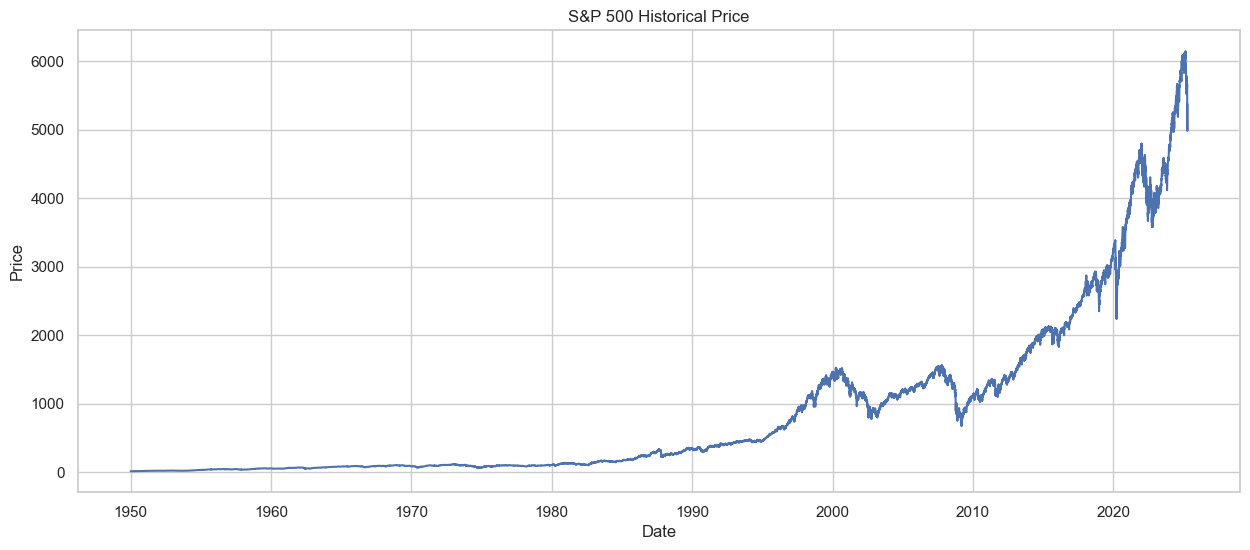

In [46]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'])
plt.title('S&P 500 Historical Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### Trading Volume Over Time

We visualize the volume of shares traded over time. Volume spikes can indicate high investor activity, which may be driven by market news or volatility.

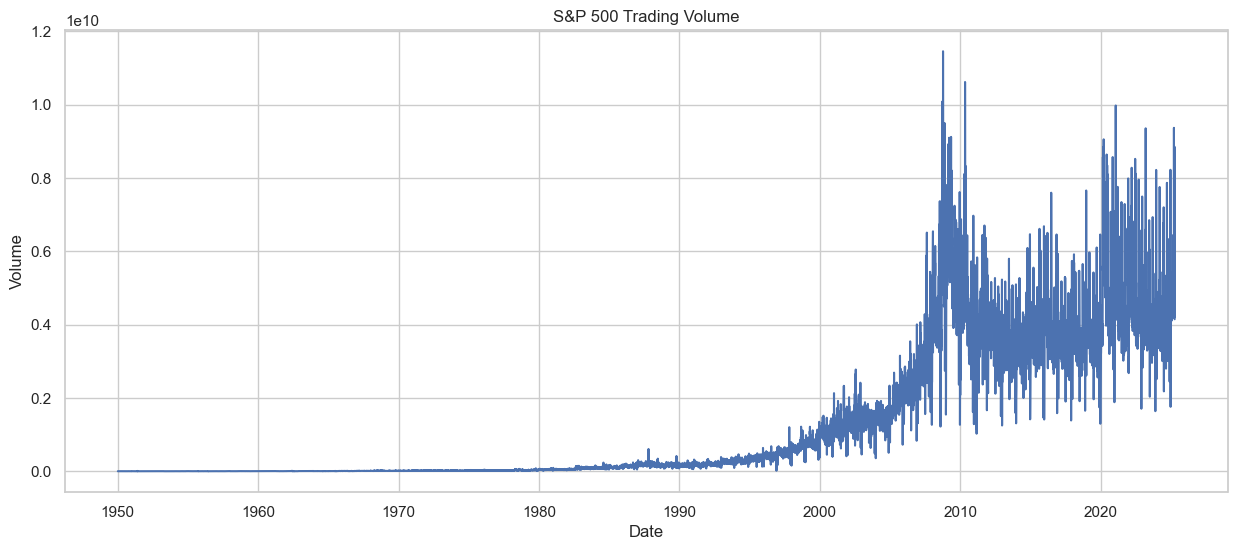

In [49]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Volume'])
plt.title('S&P 500 Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

### Correlation heatmap

We compute and visualize the correlation matrix to understand linear relationships between features. Strong correlations can indicate multicollinearity, and may also help in feature selection or dimensionality reduction.

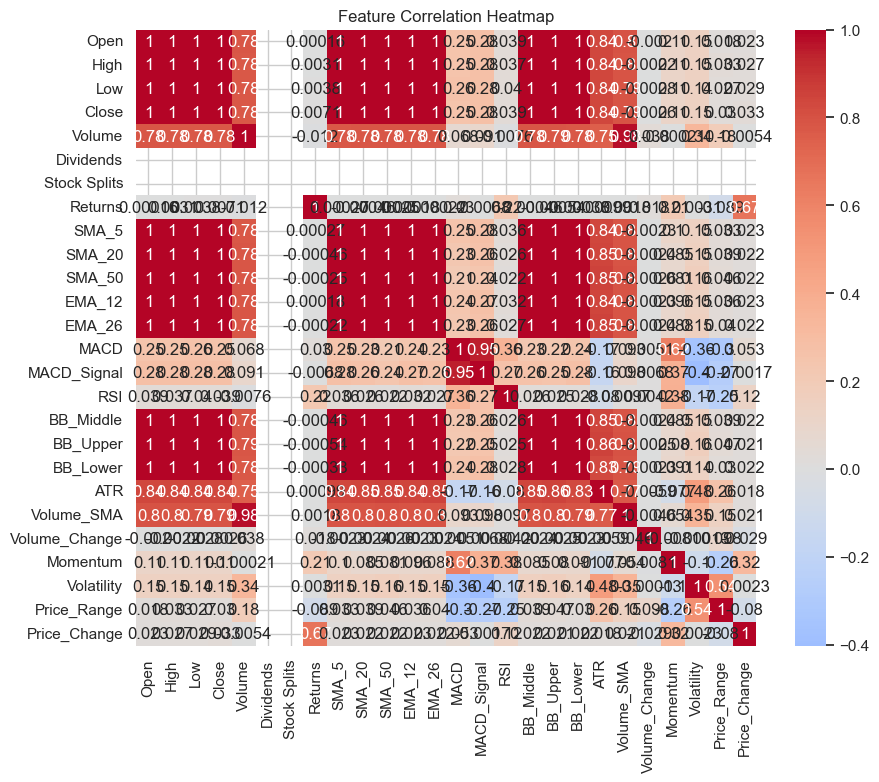

In [52]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

### Price distribution

We examine the frequency distribution of the `Close` price to check for skewness, modality, and overall shape. This helps assess whether a transformation (e.g., log) might be needed.

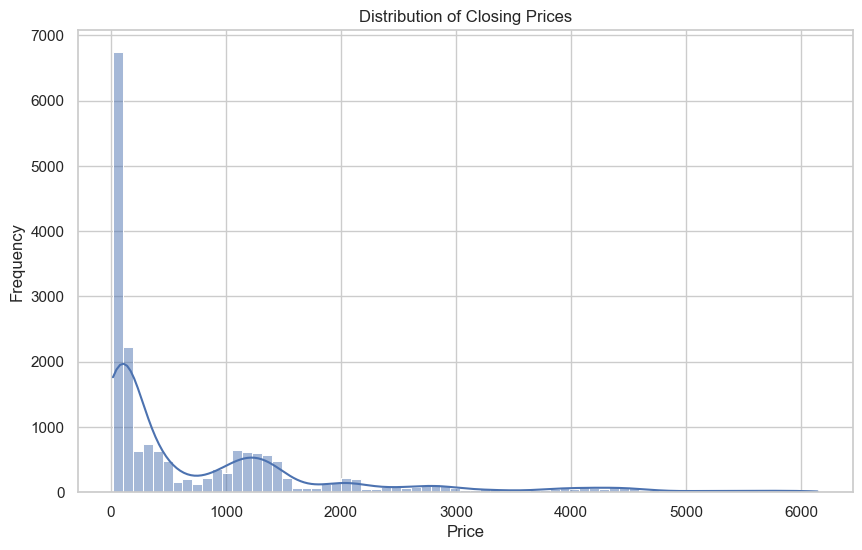

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True)
plt.title('Distribution of Closing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### Daily returns

We calculate and plot daily percentage returns to explore the volatility and shape of returns — a key aspect in financial modeling. The histogram with KDE (kernel density estimate) gives a smooth approximation of the return distribution, which is typically centered around zero and can exhibit heavy tails.

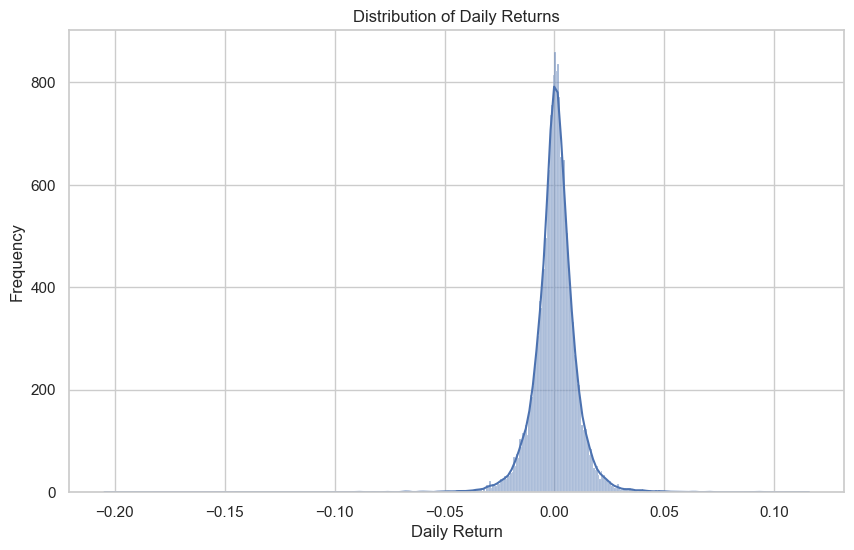

In [58]:
df['Returns'] = df['Close'].pct_change()
plt.figure(figsize=(10, 6))
sns.histplot(df['Returns'].dropna(), kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

### Preview data after EDA

In [60]:
print("\nFirst few rows of the data:")
print(df.head())


First few rows of the data:
                            Open   High    Low  Close   Volume  Dividends  \
Date                                                                        
1950-01-03 05:00:00+00:00  16.66  16.66  16.66  16.66  1260000        0.0   
1950-01-04 05:00:00+00:00  16.85  16.85  16.85  16.85  1890000        0.0   
1950-01-05 05:00:00+00:00  16.93  16.93  16.93  16.93  2550000        0.0   
1950-01-06 05:00:00+00:00  16.98  16.98  16.98  16.98  2010000        0.0   
1950-01-09 05:00:00+00:00  17.08  17.08  17.08  17.08  2520000        0.0   

                           Stock Splits   Returns   SMA_5   SMA_20  ...  \
Date                                                                ...   
1950-01-03 05:00:00+00:00           0.0       NaN  16.674  16.5780  ...   
1950-01-04 05:00:00+00:00           0.0  0.011405  16.728  16.6000  ...   
1950-01-05 05:00:00+00:00           0.0  0.004748  16.782  16.6270  ...   
1950-01-06 05:00:00+00:00           0.0  0.002953  16.84

***

# 2. Data Cleaning and Feature Selection

## Preparing the data

We begin by:
- **Dropping rows with missing values** to ensure compatibility with machine learning models.
- **Selecting engineered features**, including technical indicators such as moving averages, volatility measures, momentum, and volume-based metrics.
- Setting our **target variable** as `Close`, which represents the daily closing price of the S&P 500 index.

In [65]:
def prepare_data(df):
    # Clean data
    df = df.dropna()
    
    # Select features
    features = ['Open', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_20', 'SMA_50',
                'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI', 'BB_Middle',
                'BB_Upper', 'BB_Lower', 'ATR', 'Volume_SMA', 'Volume_Change',
                'Momentum', 'Volatility', 'Price_Range', 'Price_Change']
    target = 'Close'
    
    print("\nSelected features:", features)
    print("Target variable:", target)
    
    return df[features], df[target]

X, y = prepare_data(df)


Selected features: ['Open', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'ATR', 'Volume_SMA', 'Volume_Change', 'Momentum', 'Volatility', 'Price_Range', 'Price_Change']
Target variable: Close


## Feature Importance Analysis using Random Forest

### Run a Random Forest model to identify feature importance scores for the dataset.

To identify which features most strongly influence the closing price, we fit a **Random Forest Regressor**. This ensemble method provides built-in feature importance scores based on how much each variable reduces prediction error across decision trees.

In [69]:
print("\nAnalyzing feature importance using Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Scores:")
print(feature_importance)


Analyzing feature importance using Random Forest...

Feature Importance Scores:
          Feature    Importance
2             Low  6.302800e-01
1            High  2.818912e-01
4           SMA_5  2.015865e-02
0            Open  1.849402e-02
8          EMA_26  1.352775e-02
13       BB_Upper  1.256658e-02
7          EMA_12  9.955704e-03
5          SMA_20  6.431205e-03
12      BB_Middle  6.322214e-03
6          SMA_50  3.365961e-04
14       BB_Lower  1.568751e-05
21   Price_Change  1.121299e-05
20    Price_Range  1.176974e-06
18       Momentum  1.141093e-06
17  Volume_Change  1.038125e-06
11            RSI  9.953720e-07
3          Volume  9.848445e-07
10    MACD_Signal  8.312596e-07
16     Volume_SMA  8.252675e-07
19     Volatility  8.249033e-07
15            ATR  7.603189e-07
9            MACD  6.084081e-07


### Plot the obtained feature importance scores

In [71]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

### Select features with importance > 0.01 (1%)

To simplify the model and avoid noise from low-importance features, we:
- Retain only those features with an importance score above **1%** (`> 0.01`).
- This threshold helps reduce overfitting and improves training speed without sacrificing performance.

In [74]:
important_features = feature_importance[feature_importance['Importance'] > 0.01]['Feature'].tolist()
print(f"\nSelected important features: {important_features}")

X = X[important_features]


Selected important features: ['Low', 'High', 'SMA_5', 'Open', 'EMA_26', 'BB_Upper']


### Scale features

We scale both the selected features (`X`) and the target variable (`y`) using **MinMaxScaler**. This normalization step is crucial for many machine learning models (especially neural networks), ensuring that features contribute proportionately and training converges efficiently.

In [77]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

At the end of this process, we have:
- A reduced, high-quality feature set (`X_scaled`)
- A normalized target variable (`y_scaled`)
- Both ready for model training.

***

# 3. Implementing and Comparing Predictive Models

In this section, we train and evaluate two predictive models to forecast the S&P 500 closing price:

- A **Linear Regression model**, which serves as a simple baseline.
- A **Long Short-Term Memory (LSTM) model**, a deep learning approach well-suited for time series forecasting.

## Split data

We split the dataset into training and testing subsets using an 80/20 ratio. The time-series nature of the data means we preserve order rather than shuffling.

In [84]:
train_size = int(len(X_scaled) * 0.8)
X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size:]

## Prepare LSTM data

LSTM models require sequential input. We define a custom function that restructures the data into overlapping sequences (`time_steps = 30`), so that the model can learn from a rolling window of past values to predict the next.

In [87]:
def prepare_lstm_data(X, y, time_steps=30):
    """Prepare data for LSTM model"""
    X_lstm, y_lstm = [], []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:(i + time_steps)])
        y_lstm.append(y[i + time_steps])
    return np.array(X_lstm), np.array(y_lstm)

def create_lstm_model(input_shape):
    """Create simplified LSTM model"""
    model = Sequential([
        LSTM(50, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

time_steps = 30
X_train_lstm, y_train_lstm = prepare_lstm_data(X_train, y_train, time_steps)
X_test_lstm, y_test_lstm = prepare_lstm_data(X_test, y_test, time_steps)

## Model Architectures

### 1. Train Linear Regression Model

In [90]:
print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_pred_lr = scaler_y.inverse_transform(y_pred_lr.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test)


Training Linear Regression...


### 2. Train LSTM Model and Make Predictions

We define a minimal LSTM architecture with:
- A single LSTM layer of 50 units
- A dense output layer
- Mean Squared Error (MSE) loss and Adam optimizer

The LSTM is trained over 10 epochs with a batch size of 32.

In [93]:
print("\nTraining LSTM...")
lstm_model = create_lstm_model((time_steps, X_train_lstm.shape[2]))
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)

y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)
y_test_lstm_actual = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))


Training LSTM...
Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.9270e-04
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.7595e-06
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.5825e-06
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.5875e-06
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.1786e-06
Epoch 6/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8818e-06
Epoch 7/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.3480e-06
Epoch 8/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.1296e-06
Epoch 9/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.9983e-06
Epoch 10/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.5678e-06
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## Model Evaluation

After training both models, we:
- Generate predictions on the test set
- Inverse scale the outputs to bring them back to the original price range
- Calculate key metrics:
  - **MSE (Mean Squared Error)**: Measures average squared difference between predictions and actual values.
  - **R² Score**: Represents how well the model explains the variance in the target variable (1.0 is perfect, 0 means no predictive power).

### Calculate metrics for Linear Regression

In [97]:
mse_lr = mean_squared_error(y_test_actual, y_pred_lr)
r2_lr = r2_score(y_test_actual, y_pred_lr)

### Calculate metrics for LSTM

In [99]:
mse_lstm = mean_squared_error(y_test_lstm_actual, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm_actual, y_pred_lstm)

### Store and display the metrics results

In [101]:
results = {
    'Linear Regression': {'MSE': mse_lr, 'R2': r2_lr},
    'LSTM': {'MSE': mse_lstm, 'R2': r2_lstm}
}

print("\nModel Results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"MSE: {metrics['MSE']:.2f}")
    print(f"R2 Score: {metrics['R2']:.4f}")


Model Results:

Linear Regression:
MSE: 219.68
R2 Score: 0.9999

LSTM:
MSE: 20389.19
R2 Score: 0.9881


### Create a comparison bar plot

<Figure size 1000x600 with 0 Axes>

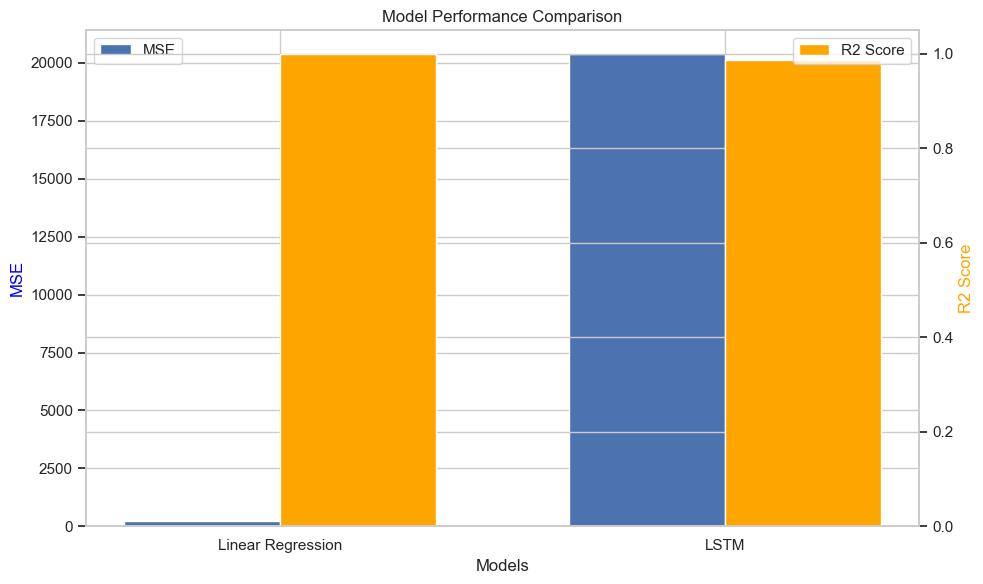

In [103]:
plt.figure(figsize=(10, 6))
models = list(results.keys())
mse_values = [results[model]['MSE'] for model in models]
r2_values = [results[model]['R2'] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

rects1 = ax1.bar(x - width/2, mse_values, width, label='MSE')
rects2 = ax2.bar(x + width/2, r2_values, width, label='R2 Score', color='orange')

ax1.set_xlabel('Models')
ax1.set_ylabel('MSE', color='blue')
ax2.set_ylabel('R2 Score', color='orange')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show() 